# Import Tools

In [103]:
import numpy as np
from scipy.integrate import solve_ivp
import tensorflow as tf
from keras import layers, models
import matplotlib.pyplot as plt
from scipy.linalg.tests.test_fblas import accuracy
from sklearn.model_selection import train_test_split

### Define RLC ODE in Python

The equation we derived for the standard form of the second-order differential equation for an RLC circuit is as follows:

$$
\frac{d^2i}{dt^2} + 2\alpha \frac{di}{dt} + \omega_0^2 i = 0
$$

In this equation:
- $2\alpha \frac{di}{dt}$ represents the damping due to resistance $R$,
- $\omega_0^2 i$ represents the restoring force due to the inductor and capacitor.

This equation describes how the current $i(t)$ changes over time in response to the parameters of the RLC circuit


The solution of this second-order ODE depends on the nature of the roots of the characteristic equation:

$s^2 + 2\alpha s + \omega_0^2 = 0$

The roots of this equation are:

$s = -\alpha \pm \sqrt{\alpha^2 - \omega_0^2}$

Depending on the values of $\alpha$ and $\omega_0$, there are three cases:

1. **Overdamped** ($\alpha > \omega_0$): The roots are real and distinct, and the solution is:
   $$
   i(t) = A e^{(-\alpha + \sqrt{\alpha^2 - \omega_0^2})t} + B e^{(-\alpha - \sqrt{\alpha^2 - \omega_0^2})t}
   $$

2. **Critically damped** ($\alpha = \omega_0$): The roots are real and repeated, and the solution is:
   $$
   i(t) = (A + Bt) e^{-\alpha t}
   $$

3. **Underdamped** ($\alpha < \omega_0$): The roots are complex, and the solution takes an oscillatory form:
   $$
   i(t) = e^{-\alpha t} (A \cos(\omega_d t) + B \sin(\omega_d t))
   $$
   where $\omega_d = \sqrt{\omega_0^2 - \alpha^2}$ is the damped natural frequency.

In [104]:
# Define the RLC ODE 
def rlc_ode(t, y, alpha, omega_0):
    i, di_dt = y
    d2i_dt2 = -2 * alpha * di_dt - omega_0**2 * i
    return [di_dt, d2i_dt2]

#  Generate Training Data

In [105]:
def generate_data(num_samples):                 # Defines the number of RLC circuit samples to generate
    t_span = (0, 10)                            # Time from 0 to 10 seconds
    t_eval = np.linspace(*t_span, 100)          # 100 equally spaced time points where i(t) will be evaluated
    initial_conditions = [1.0, 0.0]             # Assume the initial current and initial derivative of the circuit

    X_data = []                                 # Store feature vectors, which consist for RLC parameters at the time points
    y_data = []                                 # Store the traget values, which are the values of i(t) at each time point from solve the ODE

    for _ in range(num_samples):                # Loops 'num_samples' times to create a dataset with the specified number of RLC configurations.
        # Randomly generate R, L, C values b/w the values of 0.5 and 2
        R = np.random.uniform(0.5, 2.0)
        L = np.random.uniform(0.5, 2.0)
        C = np.random.uniform(0.5, 2.0)
        
        # Solving for the ODE characteristics
        # Calculate alpha and omega_0
        alpha = R / (2 * L)
        omega_0 = 1 / np.sqrt(L * C)

        # Solve the ODE
        #-----------------------------------------------------------------------------------------------------------
        # HERE IS WHERE WE CAN PLAY AROUND WITH DIFFERENT SOLVING TECHNIQUES
        # This example uses 'solve_ivp' to solve the diffeQ
        #-----------------------------------------------------------------------------------------------------------
        solution = solve_ivp(rlc_ode, t_span, initial_conditions, t_eval=t_eval, args=(alpha, omega_0))
        
        # Store R, L, C, and time points as features, and the solution as labels
        X_data.append(np.hstack(([R, L, C], t_eval)))
        y_data.append(solution.y[0])  # Only the current values

    return np.array(X_data), np.array(y_data)

### Use the fuction `generate_data` that we just defined

In [106]:
X_train, y_train = generate_data(num_samples=10000)

# Define Neural Network

In [107]:
# Step 2: Define the Neural Network Model
model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(100, activation='linear')  # Output length matches the number of time points
])

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_33 (Dense)                │ (None, 64)             │         6,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 100)            │         6,500 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,316 (67.64 KB)

 Trainable params: 17,316 (67.64 KB)

 Non-trainable params: 0 (0.00 B)

# Train the Neural Network
Here we can also modify the hyperparameters as needed

In [108]:
model.compile(optimizer='adam', loss='mse', metrics = ['accuracy'])

# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0128 - loss: 0.7391 - val_accuracy: 0.9455 - val_loss: 0.0205
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8140 - loss: 0.0211 - val_accuracy: 0.3960 - val_loss: 0.0202
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 0.0205 - val_accuracy: 0.9390 - val_loss: 0.0199
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6502 - loss: 0.0204 - val_accuracy: 0.9785 - val_loss: 0.0194
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6515 - loss: 0.0195 - val_accuracy: 0.9995 - val_loss: 0.0186
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5650 - loss: 0.0189 - val_accuracy: 0.6550 - val_loss: 0.0172
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5498 - loss: 0.0172 - val_accuracy: 0.7505 - val_loss: 0.0150
Epoch 8/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4291 - loss: 0.0145 - val_accu

# Plot the Results

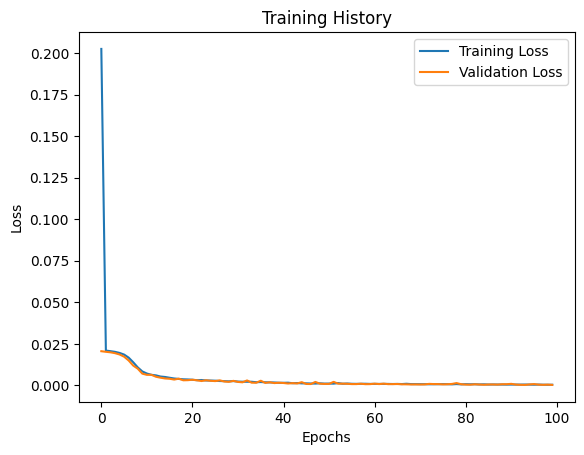

In [109]:
# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')
plt.show()


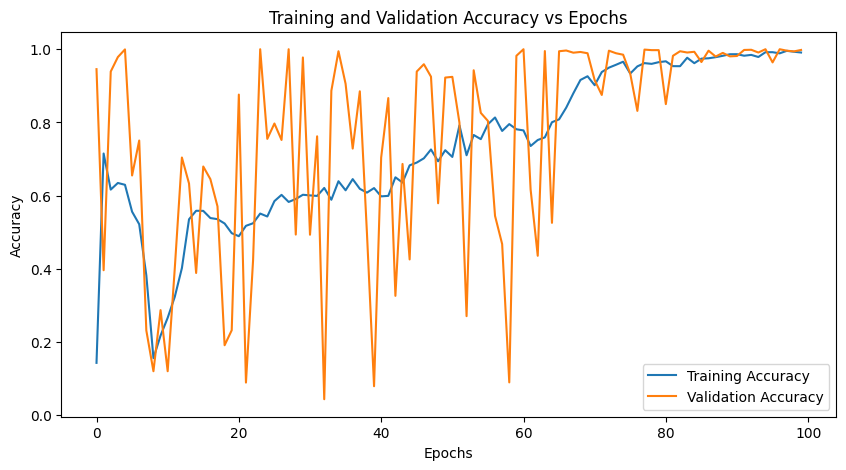

In [110]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy vs Epochs')
plt.show()

# Test the Trained Model on Test Circuit

In [111]:
# Step 4: Test the Model on New Data
R_test, L_test, C_test = 1.0, 1.0, 1.0  # Test RLC values
I0, dI0_dt = 1.0, 0
alpha_test = R_test / (2 * L_test)
omega_0_test = 1 / np.sqrt(L_test * C_test)


# Generate test time points
t_test = np.linspace(0, 10, 100)
X_test = np.hstack(([R_test, L_test, C_test], t_test))

# Predict the current using the trained model
y_pred = model.predict(X_test.reshape(1, -1)).flatten()

# Solve the ODE directly to compare
solution_test = solve_ivp(rlc_ode, (0, 10), [1.0, 0.0], t_eval=t_test, args=(alpha_test, omega_0_test))
y_true = solution_test.y[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


# Plot the NN against actual Solution

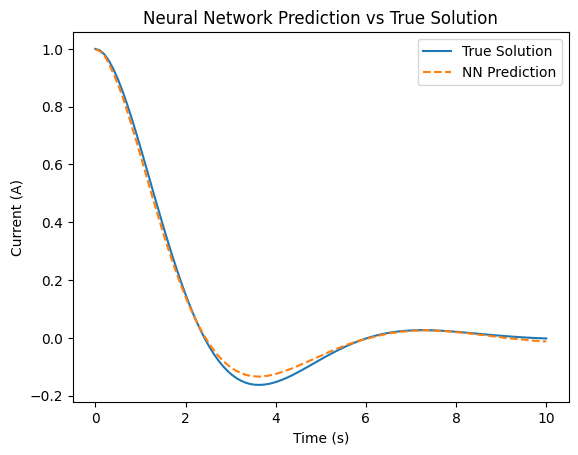

In [112]:
# Plot the neural network prediction vs actual solution
plt.plot(t_test, y_true, label='True Solution')
plt.plot(t_test, y_pred, '--', label='NN Prediction')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.legend()
plt.title('Neural Network Prediction vs True Solution')
plt.show()

### Explanation of the Code

1. **Data Generation**:
   - `generate_data` creates synthetic training samples. We randomly vary $R$, $L$, and $C$ and use `solve_ivp` to compute the current over time.
   - Each feature vector includes the parameters $R$, $L$, $C$, and the time points. Each label is the corresponding current values over time.

2. **Model Definition**:
   - A simple feedforward neural network (Multi-Layer Perceptron) is used. The input layer takes in the RLC parameters and time points, while the output layer provides the current at each time point.

3. **Training**:
   - We train the model using mean squared error (MSE) as the loss function. The `history` variable captures training progress, which we plot to ensure the model is learning.

4. **Testing**:
   - We evaluate the neural network on a new RLC configuration by comparing its prediction with the analytical solution (computed by `solve_ivp`).

### Notes
- The model might benefit from hyperparameter tuning or more sophisticated architectures, such as recurrent neural networks (RNNs) if sequential dependencies are crucial.
- In practice, this model learns to approximate the general response of an RLC circuit across different parameter values without directly solving the ODE at each time step.


# Physics Informed Neural Networks


In [145]:
# Define the RLC ODE
def rlc_ode(t, y, alpha, omega_0):
    i, di_dt = y
    d2i_dt2 = -2 * alpha * di_dt - omega_0**2 * i
    return [di_dt, d2i_dt2]


# Define the input voltage as a function of time
def voltage(t):
    return 0

In [146]:


# Define the neural network model for current I(t)
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(32, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(32, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(1, activation='linear')

    def call(self, t):
        x = self.dense1(t)
        x = self.dense2(x)
        return self.dense3(x)

In [147]:
# Define the custom loss function for the PINN
def pinn_loss(model, t, V):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(t)
        I = model(t)
        dI_dt = tape.gradient(I, t)
        d2I_dt2 = tape.gradient(dI_dt, t)

    ode_loss = L_test * d2I_dt2 + R_test * dI_dt + (1 / C_test) * I + V(t)
    ic_loss = tf.square(I[0] - I0) #+ tf.square(dI_dt[0] - dI0_dt)
    return tf.reduce_mean(tf.square(ode_loss)) + ic_loss, I



In [148]:
# Define the training step
@tf.function
def train_step(model, t, V, optimizer):
    with tf.GradientTape() as tape:
        loss, i_pred = pinn_loss(model, t, V)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss, i_pred


In [149]:
# Generate training data
t_values = np.linspace(0, 10, 1000).astype(np.float32).reshape(-1, 1)
t_train, t_test2 = train_test_split(t_values, test_size=0.2, random_state=42)


In [150]:
# Instantiate the model and optimizer
pinn_model = PINN()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

# Train the model
loss_data = []
accuracy_data = []
epochs = 2000
for epoch in range(epochs):
    loss, I_pred = train_step(pinn_model, t_train, voltage, optimizer)
    loss_data.append(loss.numpy())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.numpy()}')


Epoch 0, Loss: [1.2776504]
Epoch 100, Loss: [0.00105521]
Epoch 200, Loss: [0.00072414]
Epoch 300, Loss: [0.00054506]
Epoch 400, Loss: [0.00046103]
Epoch 500, Loss: [0.00040593]
Epoch 600, Loss: [0.00035973]
Epoch 700, Loss: [0.00031878]
Epoch 800, Loss: [0.00028241]
Epoch 900, Loss: [0.00024992]
Epoch 1000, Loss: [0.00022204]
Epoch 1100, Loss: [0.00019739]
Epoch 1200, Loss: [0.00017367]
Epoch 1300, Loss: [0.00014229]
Epoch 1400, Loss: [7.713733e-05]
Epoch 1500, Loss: [3.1534073e-05]
Epoch 1600, Loss: [2.211939e-05]
Epoch 1700, Loss: [1.9279356e-05]
Epoch 1800, Loss: [1.8005436e-05]
Epoch 1900, Loss: [2.7123044e-05]


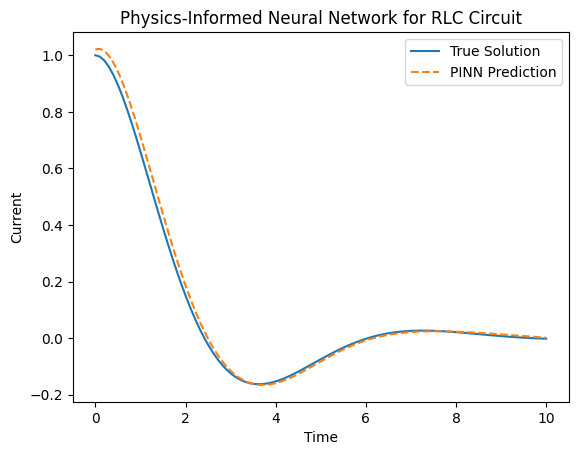

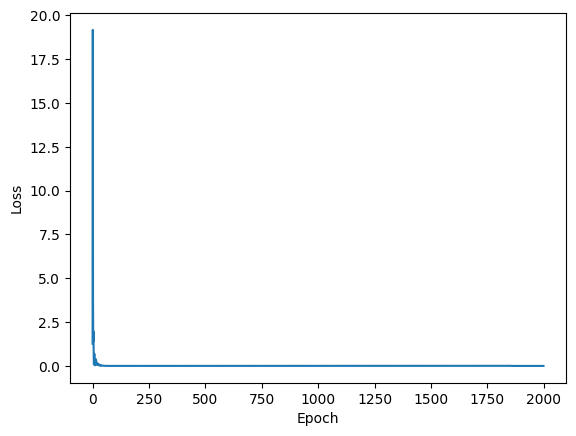

In [151]:
# Predict the current I(t) using the trained model
I_pred = pinn_model(t_values)

# Plot the results
import matplotlib.pyplot as plt


plt.plot(t_test, y_true, label='True Solution')
plt.plot(t_values, I_pred, '--', label='PINN Prediction')
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Physics-Informed Neural Network for RLC Circuit')
plt.legend()
plt.show()

plt.plot(loss_data, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()